# Categorizing Live Sellers in Thailand through KMeans Algorithm

Author: Sahngyoon Rhee

## How KMeans Algorithm Works

The KMean clustering is one of the most popular clustering machine learning algorithm, along with DBSCAN. The idea is as follows:

(1) We pick an appropriate number $k$, the number of clusters
(2) We randomly pick $k$ points in the feature space. These are initial representatives of each cluster.
(3) For each datapoint $\vec{x}$ in the dataset, calculate the distances between $\vec{x}$ and each cluster reresentative. The cluster of  $\vec{x}$ will be the cluster whose representative is the closest to $\vec{x}$.
(4) After assigning cluster labels to all datapoints, For each cluster $i$, reassign the representative of each cluster as the arithemetic mean of each datapoint in that cluster.
(5) Repeat steps (3) - (4) until we have the sum of the distances minimized or until we reach some maximum number of iterations.

The algorithm is guaranteed to converge to a result, albeit a local optimum. To reach a global optimum or at least reach a better result, we may run the algorithm multiple times.

![K-Means intuition](https://th.bing.com/th/id/R.db39eeaf3a5b79e68f882fb7705072fb?rik=wy2ZfmrbUFmaAA&pid=ImgRaw&r=0)

The value $k$ must be chosen before we run the algorithm, and the appropriate number $k$, i.e. the appropriate number of clusters, is determined by one of three methods:

1. The most obvious choice, if available. For example, when we have the MNIST dataset consisting of 10 digists, from 0 to 0, the most obvious choice of clustering would be $k = 10$.
2. The **elbow method** which we desdcribe below
3. Using the **Silhouette score**, which is a value between $-1$ and $1$ that tells us "how well" similar datapoints are clustered in a same cluster and dissimilar datapoints are clustered in different clusters. The closer the silhouette score is to $1$, the "better" the formed clusters are.

## The Dataset

In this demonstration, we shall implement the KMeanms clustering to find intrinsic groups within the dataset that has rows of information about facebook live sellers in Thailand.

The dataset has been obtain from [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Facebook+Live+Sellers+in+Thailand), and the dataset has 16 variables (including 4 null columns; see below), and consists of information gained from facebook apges of ten Thai cosmetics and fashion retail sellers. Various engagement metrics, such as the number of comments, shares, and reactions, are part of the feature variables, and all posts are of different nature, being either video, photos, statuses, or links.

In [1]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# display matplotlib plots are display inline, directly below code cells 
%matplotlib inline

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

## Dataset Exploration

We now import the dataset and do exploratory data analysis.

In [2]:
df = pd.read_csv('./data/facebook-live-sellers/Live.csv')

### Check the shape of the dataset

In [3]:
print(f'The dataframe has {df.shape[0]} rows and {df.shape[1]} features.')

The dataframe has 7050 rows and 16 features.


### Preview of the dataset

In [4]:
df.head()

,status_id,status_type,status_published,num_reactions,num_comments,num_shares,num_likes,num_loves,num_wows,num_hahas,num_sads,num_angrys,Column1,Column2,Column3,Column4
0,246675545449582_1649696485147474,video,4/22/2018 6:00,529,512,262,432,92,3,1,1,0,NaN,NaN,NaN,NaN
1,246675545449582_1649426988507757,photo,4/21/2018 22:45,150,0,0,150,0,0,0,0,0,NaN,NaN,NaN,NaN
2,246675545449582_1648730588577397,video,4/21/2018 6:17,227,236,57,204,21,1,1,0,0,NaN,NaN,NaN,NaN
3,246675545449582_1648576705259452,photo,4/21/2018 2:29,111,0,0,111,0,0,0,0,0,NaN,NaN,NaN,NaN
4,246675545449582_1645700502213739,photo,4/18/2018 3:22,213,0,0,204,9,0,0,0,0,NaN,NaN,NaN,NaN


It seems like the last four columns are all `NaN` values. We are going to confirm that this is really the case:

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7050 entries, 0 to 7049
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   status_id         7050 non-null   object 
 1   status_type       7050 non-null   object 
 2   status_published  7050 non-null   object 
 3   num_reactions     7050 non-null   int64  
 4   num_comments      7050 non-null   int64  
 5   num_shares        7050 non-null   int64  
 6   num_likes         7050 non-null   int64  
 7   num_loves         7050 non-null   int64  
 8   num_wows          7050 non-null   int64  
 9   num_hahas         7050 non-null   int64  
 10  num_sads          7050 non-null   int64  
 11  num_angrys        7050 non-null   int64  
 12  Column1           0 non-null      float64
 13  Column2           0 non-null      float64
 14  Column3           0 non-null      float64
 15  Column4           0 non-null      float64
dtypes: float64(4), int64(9), object(3)
memory 

Indeed it is. We can thus drop th last four columns:

In [6]:
df = df.iloc[:,:-4]
# we can also do df.drop(columns = ['Column1', 'Column2', 'Column3', 'Column4'], inpalce = True)
df.head()

,status_id,status_type,status_published,num_reactions,num_comments,num_shares,num_likes,num_loves,num_wows,num_hahas,num_sads,num_angrys
0,246675545449582_1649696485147474,video,4/22/2018 6:00,529,512,262,432,92,3,1,1,0
1,246675545449582_1649426988507757,photo,4/21/2018 22:45,150,0,0,150,0,0,0,0,0
2,246675545449582_1648730588577397,video,4/21/2018 6:17,227,236,57,204,21,1,1,0,0
3,246675545449582_1648576705259452,photo,4/21/2018 2:29,111,0,0,111,0,0,0,0,0
4,246675545449582_1645700502213739,photo,4/18/2018 3:22,213,0,0,204,9,0,0,0,0


In [7]:
# double check that we don't have any null values
print(df.isnull().sum())

status_id           0
status_type         0
status_published    0
num_reactions       0
num_comments        0
num_shares          0
num_likes           0
num_loves           0
num_wows            0
num_hahas           0
num_sads            0
num_angrys          0
dtype: int64


### Statistical summary of numerical variables

In [8]:
df.describe(exclude='object')

,num_reactions,num_comments,num_shares,num_likes,num_loves,num_wows,num_hahas,num_sads,num_angrys
count,7050.000000,7050.000000,7050.000000,7050.000000,7050.000000,7050.000000,7050.000000,7050.000000,7050.000000
mean,230.117163,224.356028,40.022553,215.043121,12.728652,1.289362,0.696454,0.243688,0.113191
std,462.625309,889.636820,131.599965,449.472357,39.972930,8.719650,3.957183,1.597156,0.726812
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,17.000000,0.000000,0.000000,17.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,59.500000,4.000000,0.000000,58.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,219.000000,23.000000,4.000000,184.750000,3.000000,0.000000,0.000000,0.000000,0.000000
max,4710.000000,20990.000000,3424.000000,4710.000000,657.000000,278.000000,157.000000,51.000000,31.000000


### Explore the `status_id` variable

In [9]:
df.status_id.value_counts()

status_id
819700534875473_957599447752247      2
819700534875473_972433889602136      2
819700534875473_981835315328660      2
819700534875473_980941638751361      2
819700534875473_978746665637525      2
                                    ..
246675545449582_264078163709320      1
246675545449582_264081010375702      1
246675545449582_264089710374832      1
246675545449582_264092513707885      1
1050855161656896_1050858841656528    1
Name: count, Length: 6997, dtype: int64

In [10]:
# Dispaly the number of unique values in the 'status_id' column
unique_status_ids_count = df['status_id'].nunique()
print(f"There are {unique_status_ids_count} unique status ids.")

# We may choose to display the unique values in the 'status_id' column
# unique_status_ids = df['status_id'].unique()
# print("\nUnique values in the 'status_id' column:")
# print(unique_status_ids)

There are 6997 unique status ids.


### Explore the `status_published` variable

In [11]:
# view the labels in the status_published column
df.status_published.unique()

array(['4/22/2018 6:00', '4/21/2018 22:45', '4/21/2018 6:17', ...,
       '9/21/2016 23:03', '9/20/2016 0:43', '9/10/2016 10:30'],
      dtype=object)

In [12]:
# View how many values there are for different entries in the column
df.status_published.value_counts()

status_published
3/20/2018 1:54     3
12/28/2017 8:09    2
4/30/2018 6:20     2
4/26/2018 19:00    2
4/23/2018 7:26     2
                  ..
9/6/2012 9:01      1
9/6/2012 9:16      1
9/6/2012 23:17     1
9/7/2012 0:21      1
9/10/2016 10:30    1
Name: count, Length: 6913, dtype: int64

In [13]:
# view how many variables there aer in the column
df.status_published.nunique()

6913

### Explore `status_type` variable

In [14]:
# view the labels in the variable
df.status_type.unique()

array(['video', 'photo', 'link', 'status'], dtype=object)

In [15]:
# check how many rows there are for each label
df.status_type.value_counts()

status_type
photo     4288
video     2334
status     365
link        63
Name: count, dtype: int64

## Declaring Feature and Target Variable

KMeans Clustering algorithm is for **unsupervised learning**, and it is usually used when we have unlabeled dataset. However, for the purpose of seeing how well KMeans does, we shall declare feature and target variables. We shall then use the feature and target varialbes to test how well our KMeans algorithm performs.

In [16]:
# Drop irrelevant columns first
df.drop(columns=['status_id', 'status_published'], inplace = True)

# Select the feature vector first
X = df.drop('status_type', axis = 1)

# select the target variable
y = df['status_type']

print('Example feature vectors (X):')
print(X.head(2))

print('\nExample target variables (y):')
print(y.head(2))

Example feature vectors (X):
   num_reactions  num_comments  num_shares  num_likes  num_loves  num_wows  \
0            529           512         262        432         92         3   
1            150             0           0        150          0         0   

   num_hahas  num_sads  num_angrys  
0          1         1           0  
1          0         0           0  

Example target variables (y):
0    video
1    photo
Name: status_type, dtype: object


The following will convert the categories in `status_type`, i.e. the target variables, into numeric values $1,2,3,4$.

In [17]:
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

### View the summary of X

In [18]:
display(X.describe())

,num_reactions,num_comments,num_shares,num_likes,num_loves,num_wows,num_hahas,num_sads,num_angrys
count,7050.000000,7050.000000,7050.000000,7050.000000,7050.000000,7050.000000,7050.000000,7050.000000,7050.000000
mean,230.117163,224.356028,40.022553,215.043121,12.728652,1.289362,0.696454,0.243688,0.113191
std,462.625309,889.636820,131.599965,449.472357,39.972930,8.719650,3.957183,1.597156,0.726812
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,17.000000,0.000000,0.000000,17.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,59.500000,4.000000,0.000000,58.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,219.000000,23.000000,4.000000,184.750000,3.000000,0.000000,0.000000,0.000000,0.000000
max,4710.000000,20990.000000,3424.000000,4710.000000,657.000000,278.000000,157.000000,51.000000,31.000000


In [19]:
X.head()

,num_reactions,num_comments,num_shares,num_likes,num_loves,num_wows,num_hahas,num_sads,num_angrys
0,529,512,262,432,92,3,1,1,0
1,150,0,0,150,0,0,0,0,0
2,227,236,57,204,21,1,1,0,0
3,111,0,0,111,0,0,0,0,0
4,213,0,0,204,9,0,0,0,0


## Feature Scaling

The `MinMaxScaler()` transforms a value $x \in X$ so that each feature $x_i$ gets converted to the value $\frac{x_i - \displaystyle\min_{x \in X} x_i}{\displaystyle\max_{x \in X} x_i - \displaystyle\min_{x \in X} x_i}$. The transformed vector thus has each of its features as between $0$ and $1$.

In [20]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

## KMeans Model with Two Clusters

In [21]:
kmeans = KMeans(n_clusters = 2)
kmeans.fit(X_scaled)

KMeans(n_clusters=2)

## KMeans model parameters

We now look at the cluster centers, i.e. the representatives of each cluster.

In [22]:
kmeans.cluster_centers_

array([[0.02483047, 0.00932759, 0.00889636, 0.02254048, 0.01423501,
        0.00215728, 0.00331136, 0.00441161, 0.00279261],
       [0.35566655, 0.02806954, 0.04734731, 0.34084022, 0.08499512,
        0.03631548, 0.01879727, 0.00945925, 0.01461694]])

### Inertia

*Inertia* is another measure how well a dataset was clustered by KMeans. It's the sum of squared distances between each datapoint and its centroid.

In other words, the inertia $J$ is defined as 

$J := \displaystyle\sum_{k=1}^K\sum_{\substack{i=1,...,n_k \\ \text{$x_i$ is in cluster $k$}}} ||x_i - \mu_k||^2$

where 

$\mu_k := \frac{1}{n_k} \displaystyle\sum_{i=1}^k x_k$.

We notice that setting $k = 1000$ for a dataset of $1000$ datapoints will give us a zero inertia. However, this is likely not what we want in most applications. We want the inertia is low, but we also want the number of clusters to be not large so that we can make meaningful clusters. For a KMeans clustering result to be a good clustering, we want **low inertia and a low number of clusters.** As the number of clusters, $K$, increases, the inertias tends to decrease. We want to find a right balance.

A way to find that right balance is the **Elbow method**: find the point where the decrease in inertia begins to slow.

<img src="https://content.codecademy.com/programs/machine-learning/k-means/number-of-clusters.svg">
<p>K=3 is considered an optimal number of clusters based on the above graph because it's where the 'elbow bends.'</p>

In [23]:
# explore inertia of our dataset
kmeans.inertia_

99.50082638379907

In [24]:
## Check the quality of the classification
silhouette_avg = silhouette_score(X_scaled, kmeans.labels_)
print(f"Silhouette Score for 2 clusters: {silhouette_avg}")

Silhouette Score for 2 clusters: 0.8125263296259583


[The silhouette score](https://www.youtube.com/watch?v=5TPldC_dC0s) is a score that we assign to each point after applying a clustering algorithm. 

The silhouette score is a measure of how similar a datapiont is within-cluster (cohesion) compared to other clusters (separation).

The **idea** for a clustering point $p$ in the cluster $i$ is to somehow define how well a point is situated in its cluster, i.e. measure something like
$s(p) ?\cong? \frac{\text{average of the distances between the point p and another point in the cluster i}}{\text{average of the distance between the point p and another point in the cluster j, where the cluster j is a different cluster from i}}$.

That is the *idea* and not the precise formula. There is slight modification and with justifiable reason, which you can find in this [detailed Youtube explanation](https://www.youtube.com/watch?v=wW1tgWtkj4I). The above 'formula' for the intuition behind the silhouette score is normalized so that the silhouette score of a point $p$ is between $-1$ and $1$, and the closer $s(p)$ is to $1$ the more similar a datapoint is to other points in the same cluster compared to points in other clusters.

More precisely,

$s(p) = \frac{b(p) - a(p)}{\max \{a(i), b(i) \}}$

where $a(p)$ is the average distance between $p$ and all the other datapoints in the cluster to which $p$ belongs, and $b(p)$ is the average distance between $p$ to all points outside of its cluster. For a good cluster, we want, for any datapoint $p$, $b(p)$ to be large and $a(p)$ to be small. Because we want $s(p)$ as a measure of how *well* our data is situated in-cluster compared to its situation in other clusters, the numerator $b(p) - a(p)$ makes sense. The denominator is meant to scale this number so that $s(p)$ is always between $-1$ and $1$.

<img src="https://th.bing.com/th/id/R.49c18da60dfdbe6567ba45ef98e485b2?rik=WVY5ogDm0au4Mg&riu=http%3a%2f%2fclipart-library.com%2fimages_k%2flab-puppy-silhouette%2flab-puppy-silhouette-9.png&ehk=4wlEKp02VmXD9yZ681Fw2tVAFkIUuIbtjTMCbUgCGRI%3d&risl=&pid=ImgRaw&r=0" width = 300>

<p> By analogy, silhouette score can be thought of as a measure of how any of a dog's body part is "well-situated" within the dog's body (the black part of the image) compared to its dissimilarity with anything that's not part of a dog's body (the white part).</p>

For a good cluster, we want the silhouette score for all points in our dataset to be as high as possible. For that, we calculate the average silhouette score for a given choice of $K$, across all datapoints. The value of $K$ that gives the lowest silhouette score is considered as an optimal value of $K$.

<img src="https://th.bing.com/th/id/OIP.Epu3KwJ5EDNTXMi7fusN6wAAAA?rs=1&pid=ImgDetMain">
<p>The highest sihouette score can be corerlated with the 'best' number of clusters.</p>

For demonstration, we use the inertia and elbow method to find the best number of clusters.

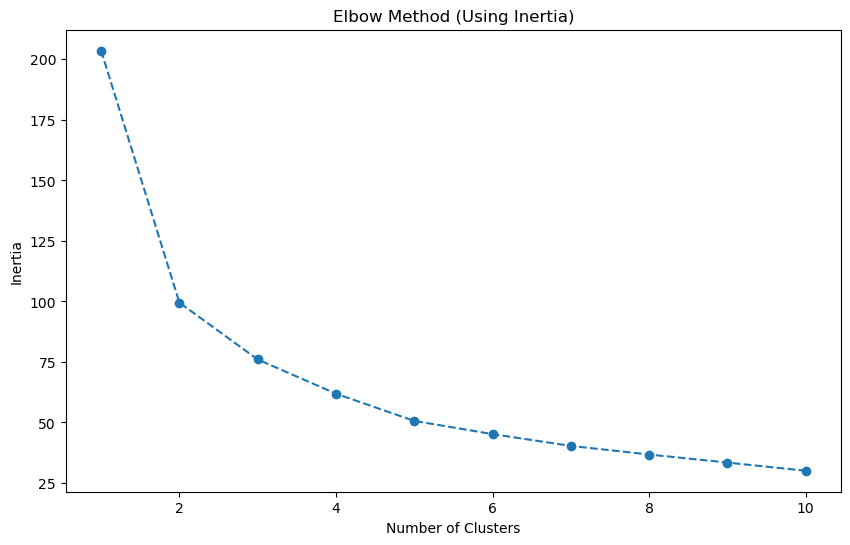

In [25]:
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters = k)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize = (10, 6))
plt.plot(range(1,11), inertia, marker = 'o', linestyle='--')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method (Using Inertia)')
plt.show()

We set our cluster to 2, since the elbow method tells us this is a reasonable choice.

In [26]:
# Set cluster = 2
kmeans2 = KMeans(n_clusters = 2)
kmeans2.fit(X_scaled)
labels = kmeans2.labels_

# check how many samples were correctly labeled

correct_labels = sum(y == labels)

print("Result: %d out of %d samples were correctly labeled." % (correct_labels, y.size))

print('Accuracy score: {0:0.2f}'. format(correct_labels/float(y.size)))

Result: 275 out of 7050 samples were correctly labeled.
Accuracy score: 0.04


## KMeans model with Different Clusters

Let us see how accurate our cluster models are across other values of $K$.

In [27]:
# Set cluster = 3
kmeans3 = KMeans(n_clusters=3, random_state=42)
kmeans3.fit(X_scaled)
labels = kmeans3.labels_

# check how many of the samples were correctly labeled

correct_labels = sum(y == labels)
print("Result: %d out of %d samples were correctly labeled." % (correct_labels, y.size))
print('Accuracy score: {0:0.2f}'. format(correct_labels/float(y.size)))

Result: 118 out of 7050 samples were correctly labeled.
Accuracy score: 0.02


In [28]:
# Set cluster = 4 
kmeans4 = KMeans(n_clusters=4, random_state=42)
kmeans4.fit(X_scaled)
labels = kmeans4.labels_

# check how many of the samples were correctly labeled

correct_labels = sum(y == labels)
print("Result: %d out of %d samples were correctly labeled." % (correct_labels, y.size))
print('Accuracy score: {0:0.2f}'. format(correct_labels/float(y.size)))

Result: 511 out of 7050 samples were correctly labeled.
Accuracy score: 0.07


We notice that the accuracies are pretty low, and that the KMeans algorithm with 4 clusters seems to perform well.

Here we make an analysis of why that may be the case:

1. The target variables were incorrectly identified.

In other words, because the KMeans algorithm categories *classes* and assigns numbers to the classes, it may be that a class that was labeled by `sklearn.preprocessing.LabelEncoder()` as $1$ may have been classified by the algorithm as $0$, and so on, so that we have such a low accuracy. This makes sense, since the lower accuracy may in fact be the highest accuracy with relabeling the target variables.

2. There are some patterns not detectable by KMeans (i.e. KMeans may not have been the best clustering algorithm in our case)

This point is further elustrated in the disadvantages of KMeans, point 3, below. Stated in simple terms, there may have been some clusters that encircle other clusters when they are plotted, so that KMeans, which is based only on distances, failed to capture such behaviors.

## Disadvantages of KMeans and Ways to Overcome Them

While the implemented `sklearn.cluster.KMeans` is a good model for clustering, KMeans has some disadvantages. We look at some of them and address ways to overcome or mitigate their effects.

1. We must choose the number of clusters, $K$, in advance.

This can be overcome by the Elbow method using Inertia or the Silhouette Analysis. Still, This may require significant more computational time as the size of the data grows.

2. KMeans is sensitive to the scale of the data.

Distance in each direction is treated as equally important - for example, if we were doing clustering of people based on their heartbeat rate and their height in feet, the height would be considered less important for clustering because for most people their height is less than $7$ feet while their heartbeat usually is over $100$ per minute. We can overcome this by rescaling our data, which was the reason why we applied `sklearn.preprocessing.MinMaxScaler()` before running our algorithm in the dataset above.

3. KMeans is sensitive to the shape of the data.

For example, we may have a dataset that has an obvious clusters but would be incorrecrtly classified by KMeans, since the KMeans seeks to label the datapoints according to how close they are to centroids:

<img src="https://th.bing.com/th/id/R.6db08990e2bfbf4f024793d15a30cc6d?rik=irVtKbcGsQt3wg&pid=ImgRaw&r=0">

For those, we can use other clustering methods that are density-based clustering, the prime example of which is DBSCAN.